In [1]:
import os
import glob

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
embeddings, labels = np.load("./encoder/embeddings.npy"), np.load("./encoder/labels.npy")
embeddings.shape, labels.shape

((555, 256), (555,))

In [3]:
clf = SGDClassifier(loss='log')
clf.fit(embeddings, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [4]:
encoder = tf.keras.models.load_model("./encoder/model_x64_x32_x16_256.h5", compile=False)

encoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                   loss=tfa.losses.TripletSemiHardLoss())

In [5]:
frontalface_default_cascade = cv2.CascadeClassifier("./opencv-haarcascade/haarcascade_frontalface_default.xml")
profileface_cascade = cv2.CascadeClassifier("./opencv-haarcascade/haarcascade_profileface.xml")

In [6]:
def detect_faces(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    frontalfaces = frontalface_default_cascade.detectMultiScale(gray, 1.03, 3, 0, (32, 32))
    profilefaces = profileface_cascade.detectMultiScale(gray, 1.03, 3, 0, (32, 32))
    faces = list(filter(lambda x: len(x) > 0, [frontalfaces, profilefaces]))
    if len(faces) == 0:
        return np.array([], dtype=np.int32)
    else:
        return np.concatenate(faces)

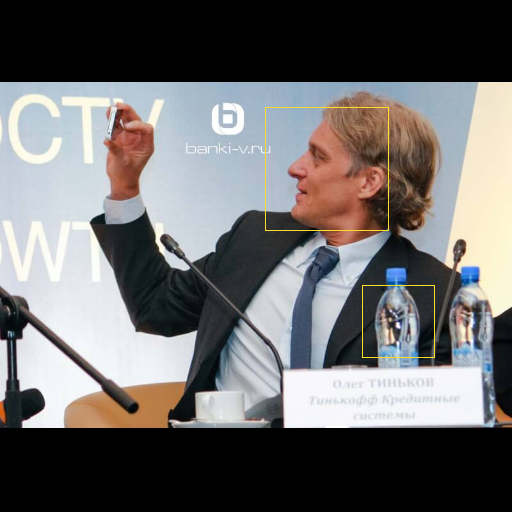

In [7]:
img_path = "./data/images/20.jpg"

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = tf.image.resize_with_pad(img_rgb, 512, 512).numpy().astype(np.uint8)
faces = detect_faces(img_rgb)

img = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(img)
for x, y, w, h in faces:
    draw.rectangle([(x, y), (x + w, y + h)], outline=(255, 221, 45), width=1)

img

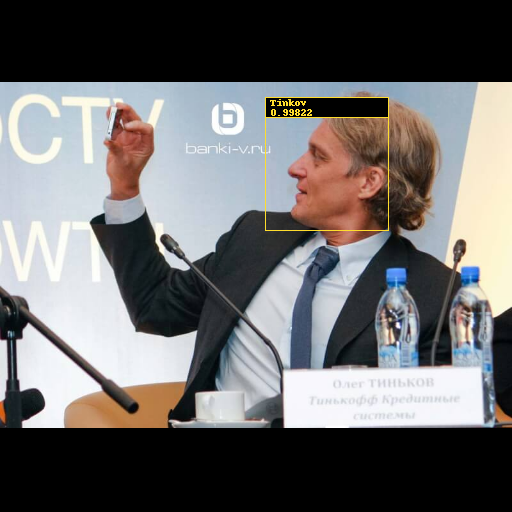

In [8]:
img = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(img)
for i, (x, y, w, h) in enumerate(faces):
    face = tf.image.convert_image_dtype(img_rgb[y:y+h, x:x+w], tf.float32)
    face = tf.image.resize_with_pad(face, 32, 32)
    
    embedding = encoder.predict(np.expand_dims(face, axis=0))
    prob = clf.predict_proba(embedding)[0, 1]

    if prob > 0.7:
        draw.rectangle([(x, y), (x + w, y + h)], outline=(255, 221, 45), width=1)
        draw.rectangle((x, y-10, x+w, y+10), fill=(0, 0, 0), outline=(255, 221, 45))
        draw.text((x, y-10), ' Tinkov', fill=(255, 221, 45))
        draw.text((x, y), f' {prob:.5f}', fill=(255, 221, 45))

img